**Model number 2**

Setting kaggle API in order to import our dataset

In [ ]:
# Importing gdown to download the file
!pip install gdown
# URL of the file on Google Drive
file_url = "https://drive.google.com/uc?id=1wIAN3-w7FpE893ynMvOxRO6smQ96adTx"
# Command to download the file
!gdown {file_url}
#install kaggle
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

Downloading...
From: https://drive.google.com/uc?id=1wIAN3-w7FpE893ynMvOxRO6smQ96adTx
To: /content/kaggle.json
100% 66.0/66.0 [00:00<00:00, 159kB/s]


In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2

Importing the dataset-
- dataset link: https://www.kaggle.com/datasets/cdeotte/jpeg-melanoma-512x512

In [ ]:
# Download latest version
path = kagglehub.dataset_download("cdeotte/jpeg-melanoma-512x512")
print("Path to dataset files:", path)

100%|██████████| 2.63G/2.63G [00:31<00:00, 89.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/cdeotte/jpeg-melanoma-512x512/versions/3


opening the train data from our dataset

In [ ]:
# path of  the csv and the image folder
train_csv_path = os.path.join(path, "train.csv")
image_folder_path = os.path.join(path, "train")

# Load CSV data
df_train = pd.read_csv(train_csv_path)

# Add .jpg extension to image names for matching
df_train['image_name'] = df_train['image_name'].apply(lambda x: f"{x}.jpg")

selecting only 5500 pictures- 550 are labeled as cancer and 5000 as no cancer

In [ ]:
df = pd.read_csv(train_csv_path)
print("CSV Loaded. Columns:", df.columns)

#taking from the dataset 5500 images
#550 pictures of melanoma (this is the maximum we have on the dataset) and the rest is not melanoma
df_0 = df[df['target'] == 0].sample(n=5000, random_state=42)  # no cancer
df_1 = df[df['target'] == 1].sample(n=550, random_state=42)  # cancer

CSV Loaded. Columns: Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target', 'tfrecord', 'width', 'height'],
      dtype='object')


In [ ]:
import shutil

#creating folders to classification
train_dir = '/content/dataset/train'
os.makedirs(f"{train_dir}/0", exist_ok=True)
os.makedirs(f"{train_dir}/1", exist_ok=True)

# copying images to the folders
print("Copying images...")
for _, row in df_0.iterrows():
    src = os.path.join(path, "train", f"{row['image_name']}.jpg")
    dest = os.path.join(f"{train_dir}/0", f"{row['image_name']}.jpg")
    if os.path.exists(src):
        shutil.copy(src, dest)

for _, row in df_1.iterrows():
    src = os.path.join(path, "train", f"{row['image_name']}.jpg")
    dest = os.path.join(f"{train_dir}/1", f"{row['image_name']}.jpg")
    if os.path.exists(src):
        shutil.copy(src, dest)

# checking the content in the folders
print("Number of images in '0':", len(os.listdir(f"{train_dir}/0")))
print("Number of images in '1':", len(os.listdir(f"{train_dir}/1")))


Copying images...
Number of images in '0': 5000
Number of images in '1': 550


Preprocessing the images with ImageDataGenerator:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# setting ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% training, 20% validation
)

In [ ]:
# Create an ImageDataGenerator with augmentation options
aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      # Rotate images up to 30 degrees
    width_shift_range=0.2,  # Shift width by up to 20%
    height_shift_range=0.2, # Shift height by up to 20%
    shear_range=0.2,        # Apply shear transformation
    zoom_range=0.2,         # Zoom in and out up to 20%
    horizontal_flip=True,   # Flip images horizontally
    fill_mode='nearest'     # Fill missing pixels
)

# Target number of images for each class
target_size = 2700  # Number of images for class 0

# Create a new directory for saving oversampled images
oversample_dir = '/content/dataset/oversampled'
os.makedirs(f"{oversample_dir}/0", exist_ok=True)
os.makedirs(f"{oversample_dir}/1", exist_ok=True)

# Copy images from class 0 to the new directory
for image_name in os.listdir(f"{train_dir}/0"):
    shutil.copy(f"{train_dir}/0/{image_name}", f"{oversample_dir}/0/{image_name}")

# Duplicate and augment melanoma images until the target size is reached
df_1_files = os.listdir(f"{train_dir}/1")
i = 0
while len(os.listdir(f"{oversample_dir}/1")) < target_size:
    img_path = f"{train_dir}/1/{df_1_files[i % len(df_1_files)]}"
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    augmented_images = aug_datagen.flow(img, batch_size=1)

    # Save an augmented image
    aug_img = augmented_images[0][0] * 255  # Remove normalization
    save_path = f"{oversample_dir}/1/aug_{i}.jpg"
    cv2.imwrite(save_path, aug_img.astype(np.uint8))
    i += 1

# Verify the number of images in each class
print("Number of images in '0':", len(os.listdir(f"{oversample_dir}/0")))
print("Number of images in '1':", len(os.listdir(f"{oversample_dir}/1")))

# Update ImageDataGenerator to use the oversampled directory
train_generator = datagen.flow_from_directory(
    oversample_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    oversample_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Number of images in '0': 5000
Number of images in '1': 2700
Found 6160 images belonging to 2 classes.
Found 1540 images belonging to 2 classes.


Definding the model- our model is a base model called MobileNetV2.
* MobileNetV2 is pre-trained on ImageNet, and the top layers are removed to customize for binary classification.
* The model uses a Global Average Pooling layer, followed by Dense layers to output a single class prediction with sigmoid activation.
* The base model layers are frozen (non-trainable) to retain the pre-trained features and avoid overfitting.
* The model is compiled with the Adam optimizer and binary crossentropy loss, using accuracy, precision, and recall as evaluation metrics.



In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import metrics

# building the model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model_2 = Model(inputs=base_model.input, outputs=predictions)

# freezing layers in basic model
for layer in base_model.layers:
    layer.trainable = False

# compiling
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',
                                                                       metrics.Precision(),
                                                                       metrics.Recall()])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# training the model
history_2 = model_2.fit(
    train_generator,
    validation_data=val_generator,
    epochs= 5
)

# saving the model
model_2.save('/content/melanoma_detection_model.h5')
print("Model saved at /content/melanoma_detection_model.h5")


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


193/193 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.9394 - loss: 0.1222 - precision: 0.9171 - recall: 0.9051 - val_accuracy: 0.9981 - val_loss: 0.0097 - val_precision: 0.9945 - val_recall: 1.0000
Epoch 2/5
193/193 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.9968 - loss: 0.0117 - precision: 0.9964 - recall: 0.9949 - val_accuracy: 0.9929 - val_loss: 0.0196 - val_precision: 0.9800 - val_recall: 1.0000
Epoch 3/5
193/193 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.9974 - loss: 0.0067 - precision: 0.9958 - recall: 0.9966 - val_accuracy: 0.9987 - val_loss: 0.0061 - val_precision: 1.0000 - val_recall: 0.9963
Epoch 4/5
193/193 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.9978 - loss: 0.0070 - precision: 0.9978 - recall: 0.9957 - val_accuracy: 0.9987 - val_loss: 0.0039 - val_precision: 0.9963 - val_recall: 1.0000
Epoch 5/5
193/193 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 1.0000 - loss: 9.2145e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0024 -

Model saved at /content/melanoma_detection_model.h5


Predicting with the model on the test images, we take 6000 images from the test folder.

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

def check_test_folder_and_predict(test_folder_path, model, max_images=6000, batch_size=32):
    image_files = [f for f in os.listdir(test_folder_path) if f.endswith('.jpg')][:max_images]
    predictions = []

    for i in range(0, len(image_files), batch_size):
        batch_files = image_files[i:i + batch_size]
        batch_images = []

        for image_file in batch_files:
            image_path = os.path.join(test_folder_path, image_file)
            try:
                # טעינת התמונה
                img = image.load_img(image_path, target_size=(224, 224))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array /= 255.0  # normalization

                batch_images.append(img_array)
            except Exception as e:
                print(f"Error processing {image_file}: {e}")
                continue

        if batch_images:
            batch_images = np.vstack(batch_images)  # Stack images into a single array
            preds = model.predict(batch_images)
            preds = (preds > 0.5).astype(int).flatten()
            predictions.extend(preds)

    return predictions

# usage
test_folder_path = os.path.join(path, "test")
predictions = check_test_folder_and_predict(test_folder_path, model_2)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━

Calculating the F1 Score

In [ ]:
from sklearn.metrics import f1_score

# Assuming 'y_true' contains the true labels for the validation set
# and 'y_pred' contains the predictions of model_2 on the validation set.
# You might need to generate these based on your validation data and model_2.

# Example:
y_true = val_generator.classes  # True labels from the validation generator
y_pred = (model_2.predict(val_generator) > 0.5).astype("int32")  # Predictions from model_2

# Calculate the F1 score
f1 = f1_score(y_true, y_pred)
print(f"F1 Score for model_2: {f1}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step
F1 Score for model_2: 0.3744207599629286


Visualisation of the training:

49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step


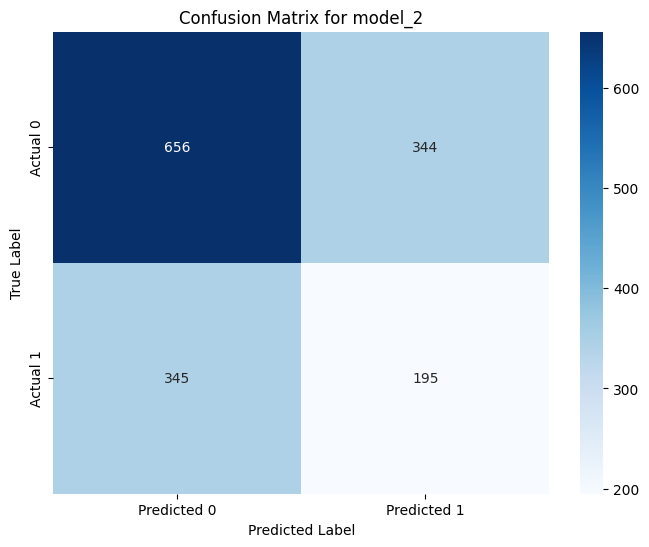

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = val_generator.classes  # True labels from the validation generator
y_pred = (model_2.predict(val_generator) > 0.5).astype("int32")  # Predictions from model_2

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for model_2')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

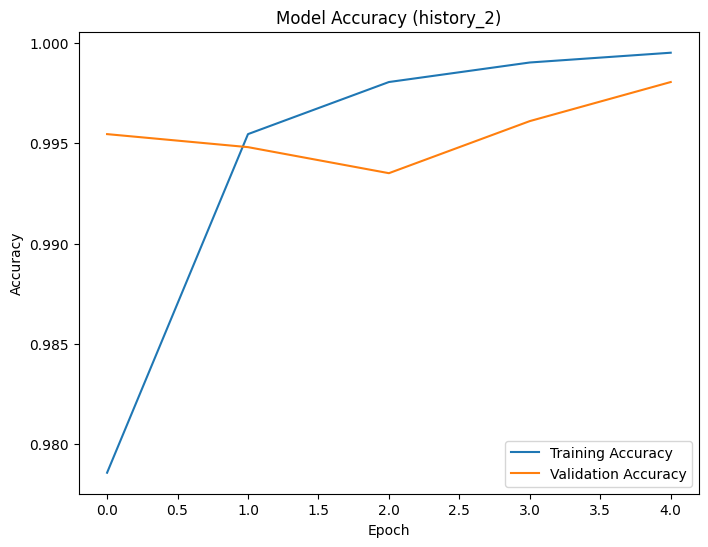

In [ ]:
#create a line plot of accuracy
plt.figure(figsize=(8, 6))
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (history_2)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

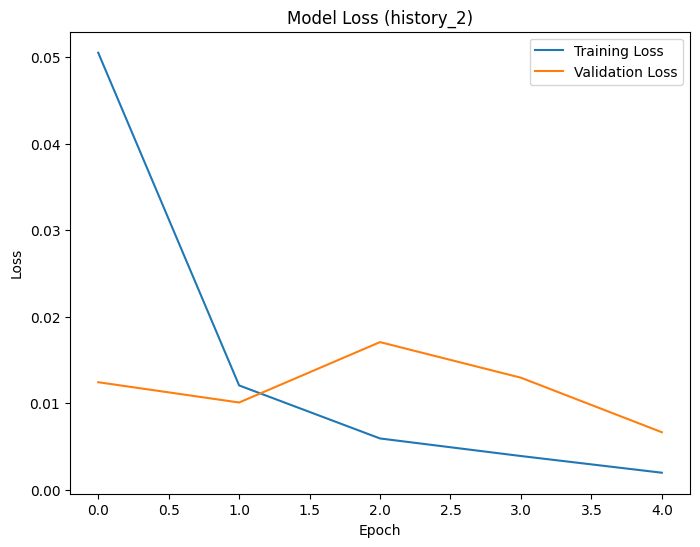

In [ ]:
#create a line plot of loss

plt.figure(figsize=(8, 6))
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (history_2)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

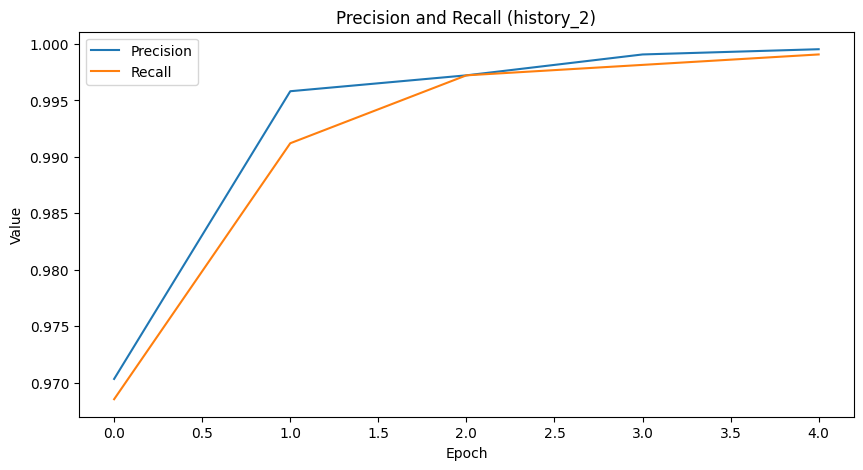

In [ ]:
# create a precision and recall visualization

plt.figure(figsize=(10, 5))
plt.plot(history_2.history['precision'], label='Precision')
plt.plot(history_2.history['recall'], label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Precision and Recall (history_2)')
plt.show()

Saving WhatsApp Image 2025-01-09 at 10.16.28.jpeg to WhatsApp Image 2025-01-09 at 10.16.28.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction for WhatsApp Image 2025-01-09 at 10.16.28.jpeg: 1


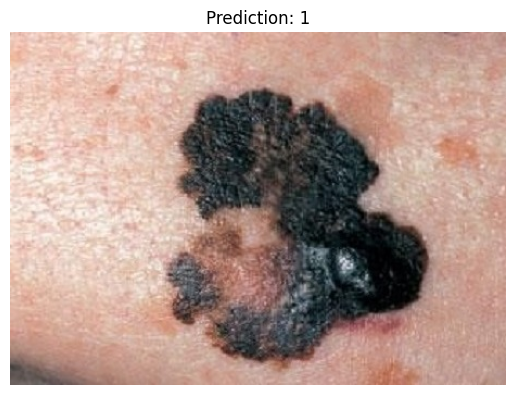

In [ ]:
# another prediction- takes any picture that we choose from our computer
from google.colab import files
import io
import numpy as np
from PIL import Image

uploaded = files.upload()

for fn in uploaded.keys():
  image = Image.open(io.BytesIO(uploaded[fn]))
  image = np.array(image)

  # Preprocess the image (same as in your training)
  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
  img = cv2.resize(img, (128, 128))  # Resize to a consistent shape
  img = img / 255.0  # Normalize pixel values to [0,1]
  img = np.expand_dims(img, axis=0) # Add batch dimension

  # Make the prediction
  prediction = model_2.predict(img)
  predicted_class = 1 if prediction > 0.5 else 0

  print(f"Prediction for {fn}: {predicted_class}")

  # Display the image
  import matplotlib.pyplot as plt
  plt.imshow(image)
  plt.title(f"Prediction: {predicted_class}")
  plt.axis('off')
  plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# path for an image for example
img_path = os.path.join(f"{train_dir}/1", os.listdir(f"{train_dir}/1")[0])  # example of image with target=1 (melanoma)

print(img_path)
# load the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # normalization

# prediction
prediction = model_2.predict(img_array)
result = 'Malignant (Cancer Detected)' if prediction[0][0] > 0.5 else 'Benign (No Cancer Detected)'
print(f"Prediction for the image: {result}")


/content/dataset/train/1/ISIC_9754098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction for the image: Benign (No Cancer Detected)


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
count = 0
count_not = 0

# Get a list of all image files in the directory
image_files = os.listdir(f"{train_dir}/1")

# Iterate over the image files using their index
for i in range(len(image_files)):
  img_path = os.path.join(f"{train_dir}/1", image_files[i])
  # טעינת התמונה
  img = image.load_img(img_path, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0  # normalization

  # תחזית
  prediction = model_2.predict(img_array)
  result = 'Malignant (Cancer Detected)' if prediction[0][0] > 0.5 else 'Benign (No Cancer Detected)'
  #print(f"Prediction for the image: {result}")
  if result == 'Malignant (Cancer Detected)':
    count += 1
  else:
    count_not +=1
print(count_not)
print(count)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━